# 20251971 - Bayan Nezamabad, 21321302 - Sam Ennis, 21308128 - Milan Kovacs
## Execution runs to end without error

# Setup


In [1]:
from packaging import version
import tensorflow as tf
import sys
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
# Make sure its running on GPU
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

We downgrade our Atari version from 1.0.0 tp 0.29.1

The If statement checks the environment of running the application, whether it is in Google Colab or local.

In [ ]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install gymnasium[atari]==0.29.1
    %pip install gymnasium[classic_control,box2d,accept-rom-license,ActionWrapper]==0.29.1
else:
    !pip install -q -U gymnasium swig
    !pip install gymnasium[atari]==0.29.1
    !pip install gymnasium[classic_control,box2d,accept-rom-license]==0.29.1

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0


In [ ]:
# Verify installation
import gymnasium as gym
sorted(gym.envs.registry.keys())[:5] + ["..."]

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

# The Game


We will apply DQN learning to Demon Attack. We will be using the Deterministic version which is deterministically skips every 4th frame. Rather than using the standard version, where the frame skipping is inconsistent. This should make learning a bit more reliable with the removal of the random event.

## About the environment
The environment consists of tuple of two objects:
- The state observation
- Info object


### The state
The state is an array of the 3 pixel channel arrays: list([R, G, B], ...)

### Info dictionary
The info dictionary contains 4 elements, the lives counter, episode_frame_number, frame_number, seeds. We will be extracting the lives value to punish the agent for losing a life/losing the game.

In [ ]:
env = gym.make('DemonAttackDeterministic-v4', render_mode="rgb_array")
obs = env.reset(seed=SEED)
obs

(array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148],
         ...,
         [  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148]],
 
        [[  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148],
         ...,
         [  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148]],
 
        [[  0,   0, 148],
         [  0,   0, 148],
         [  0,   0, 148],
         ...,
         [  0,   0, 148],
  

## Environment in detail

In [ ]:
img = env.render()
img.shape

C:\ProgramData\anaconda3\envs\tf\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


(210, 160, 3)

### Evaluation of the frame
The frames are rendered in 210 by 160 pixels, through 3 channels (RGB).

The game consists of a platform represented by the blue rectangle on the bottom.
The agent is the purple ship on the bottom. It can move left and right, and fire a bullet, represented by the purple vertical line in the picture.
The enemies spawn from the sides. There are three types of enemies, you have
- Demons: These enemies fly in
- Split Demons: Consists of 2 halves, coming from the edges and merging somewhere in the black section of the screen.
- Diver Demons:

The demons fire bullets represented by the short red dashes. The enemies will then float around with the hopes to land shots on the agent.

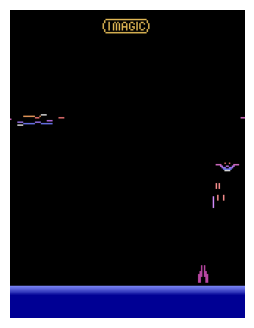

In [ ]:
import matplotlib.pyplot as plt

def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img = env.render()
  plt.imshow(img)
  plt.axis("off")
  return img

plot_environment(env)
plt.show()

### The inputs
There are 6 inputs in the game, can as shown by the first number in the cell below.

The 6 actions maps from 0 to 5 with the moves: Noop, Fire, Right, Left, Right and Fire, Left and fire respectively.

Image taken from: https://ale.farama.org/environments/demon_attack/

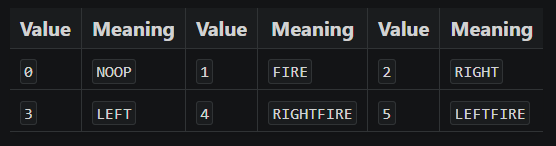

In [ ]:
n_actions = env.action_space.n
input_shape = env.observation_space.shape

print(n_actions)
print(input_shape)

6
(210, 160, 3)


source: https://atariage.com/manual_html_page.php?SoftwareLabelID=588

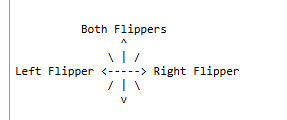

In [ ]:
# Constants
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# We are using Pinball Deterministic
# This skips every fourth frame/tick
# We are using the pixels in the environment to learn as we believe it best mimics a human learning to play
env_string = 'DemonAttackDeterministic-v4'

class DQN():
  def __init__(self,
               env_string,
               batch_size=64):
    self.memory = deque(maxlen=100_000)
    self.env = gym.make(env_string)

    input_size = (84, 84, 1)
    action_size = self.env.action_space.n

    print(f'self.env.observation_space = {self.env.observation_space}')
    print(f'input_size = {input_size}')
    print(f'action_size = {action_size}')

    self.batch_size = batch_size
    self.gamma = 1.0
    self.epsilon = 1.0
    self.epsilon_min = 0.01
    # This decay rate implies we will need ~920 episodes to reach epsilon_min as it reduces the epsilon by 0.5% per episode
    self.epsilon_decay = 0.99 # <== Changed from 0.995
    alpha=0.01
    # todo: what is this supposed to do?
    alpha_decay=0.01
    #if MONITOR: self.env = gym.wrappers.Monitor(self.env, '../data/'+env_string, force=True)

    self.build_model(input_size, action_size, alpha)

    self.fixed_agent = tf.keras.models.clone_model(self.model)
    self.fixed_agent.set_weights(self.model.get_weights())


  def build_model(self, input_shape, n_actions, alpha):
    # Init model
    self.model = Sequential()
    self.model.add(Input(shape=input_shape))
    self.model.add(BatchNormalization())
    # Convolutional layers
    self.model.add(Conv2D(32, (2, 2), strides=2, activation='relu'))
    self.model.add(BatchNormalization())
    #self.model.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
    #self.model.add(BatchNormalization())
    self.model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
    self.model.add(BatchNormalization())

    # Fully connected layers
    self.model.add(Flatten())
    self.model.add(Dense(32, activation='relu'))
    self.model.add(Dense(n_actions, activation='linear'))

    # Compile
    self.model.compile(loss = 'mse', optimizer=Adam(learning_rate = alpha))

  # Add the step to memory
  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  # Epsilon greedy strategy
  def choose_action(self, state):
    if np.random.random() <= self.epsilon:
      # Randomly choose a random (exploratory) move based on epsilon
      # Epsilon is the chance of choosing an exploratory move
      return self.env.action_space.sample()
    else:
      # Otherwise choose an exploitative move
      # From our model's predictions we choose what it thinks is most likely to be the optimal move
      return np.argmax(self.fixed_agent.predict(state, verbose=0)) # <== CHANGED FOR FIXED DQN

  # Preprocessing the state to reduce computation as we are using the resolution of the game (210x160x3)
  def preprocess_state(self, state):
      if len(state) == 2:
        img = state[0]
      else:
        img = state
      # Trim out the top (score & lives) and bottom (black space) as it contains no useful information for our model
      # img = img[22:192]
      # Reduce the number of channels from 3 to 1 as colour is unlikely to have a big effect on performance
      img = tf.image.rgb_to_grayscale(img)
      # Scaling down the image to a more manageable size
      # todo: does aspect ratio have an effect on learning?
      img = tf.image.resize([img], [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      img = tf.cast(img, tf.float32)
      return img

  def replay(self, batch_size):
    if len(self.memory) < batch_size:
      return

    x_batch, y_batch = [], []
    minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
    for state, action, reward, next_state, done in minibatch:
      y_target = self.model.predict(state, verbose=0)
      y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state, verbose=0)[0])
      x_batch.append(state[0])
      y_batch.append(y_target[0])

    self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)

  def train(self, epochs = 50):
    scores = deque(maxlen=100)
    avg_scores = []

    score_cap = 1_000_000
    frame_cap = 2_000
    for episode in range(epochs):
      state, info = self.env.reset()
      self.lives_remaining = info.get('lives', 1)

      state = self.preprocess_state(state)
      done = False
      # Score is no. of ticks survived
      score = 0
      frame_count = 0
      while not done:
        action = self.choose_action(state)
        next_state, reward, done, _, info = self.env.step(action)
        next_state = self.preprocess_state(next_state)

        # Punish agent for losing a life
        current_lives = info.get('lives')
        if current_lives < self.lives_remaining:
            print("Life lost")
            reward -= 500
            self.lives_remaining = current_lives

        self.remember(state, action, reward, next_state, done)
        state = next_state
        score += reward

        frame_count += 1

        if frame_count >= frame_cap:
          print(f"Frame cap has been reached: {frame_cap} frames for episode {episode + 1}")
          break

        #if action == 0:
        #   reward -= 0.1

        # if score >= score_cap:
        #   print(f"Score cap has been reached: {score_cap} points for epside {episode + 1}")
        #   break


      scores.append(score)
      mean_score = np.mean(scores)
      avg_scores.append(mean_score)

      print(f'Episode {episode+1}/{epochs} complete, score: {score}, epsilon: {np.round(self.epsilon, 4)}')
      if (episode+1) % 20 == 0:
        print(f'[Episode {episode+1}] - Mean survival time over last 20 episodes was {mean_score} ticks.')

      if ((episode + 1) % 10) == 0:
        print(f'Updating target Agent for epside {episode + 1} onwards')
        self.fixed_agent.set_weights(self.model.get_weights())

      if (episode) == 35:
        self.epsilon = 0.40

      self.replay(self.batch_size)
      # Decrease epsilon after each episode to gradually shift from random to learned actions
      self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon)

    return avg_scores


agent = DQN(env_string)

# agent.model.summary()

self.env.observation_space = Box(0, 255, (210, 160, 3), uint8)
input_size = (84, 84, 1)
action_size = 6


## Fixed DQN

In [ ]:
scores = agent.train()

Life lost
Episode 1/50 complete, score: -400.0, epsilon: 1.0
Life lost
Episode 2/50 complete, score: -325.0, epsilon: 0.99
Life lost
Episode 3/50 complete, score: -430.0, epsilon: 0.9801
Frame cap has been reached: 2000 frames for episode 4
Episode 4/50 complete, score: 150.0, epsilon: 0.9703
Life lost
Episode 5/50 complete, score: -360.0, epsilon: 0.9606
Life lost
Episode 6/50 complete, score: -370.0, epsilon: 0.951
Life lost
Episode 7/50 complete, score: -145.0, epsilon: 0.9415
Frame cap has been reached: 2000 frames for episode 8
Episode 8/50 complete, score: 370.0, epsilon: 0.9321
Life lost
Episode 9/50 complete, score: -235.0, epsilon: 0.9227
Life lost
Episode 10/50 complete, score: -360.0, epsilon: 0.9135
Updating target Agent for epside 10 onwards
Life lost
Episode 11/50 complete, score: -280.0, epsilon: 0.9044
Life lost
Episode 12/50 complete, score: -175.0, epsilon: 0.8953
Life lost
Episode 13/50 complete, score: -380.0, epsilon: 0.8864
Life lost
Episode 14/50 complete, score:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load scores from scores.npy
scores = np.load('scores.npy')

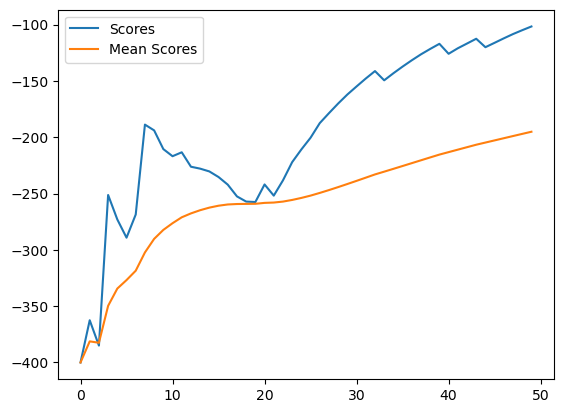

In [6]:
# Plot the mean against the scores
mean_scores = list()
for i in range(0, len(scores)):
    mean_scores.append(np.mean(scores[:i+1]))
    
plt.plot(scores, label='Scores')
plt.plot(mean_scores, label='Mean Scores')
plt.legend()
plt.show()

In [ ]:
agent.model.save('dqn_model.h5')
np.save('scores.npy', scores)

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [ ]:
# Sauce: https://colab.research.google.com/github/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb#scrollTo=GT0x6sxhjrhf
import matplotlib.pyplot as plt
import matplotlib.animation as animation

name_of_video = "Demon_Attack_play_one_episode.mp4"

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    anim.save('episode_video.mp4', writer="ffmpeg", fps=15)
    print(f"Saved video to {name_of_video}")
    plt.close()
    return anim

def show_open_episode(agent, seed = 42):
    frames = []
    frame_cap = 10_000
    agent.env = gym.make("DemonAttackDeterministic-v4", render_mode="rgb_array")
    for episode in range(1):
        state, info = agent.env.reset(seed=SEED)
        agent.current_lives = info.get('info', 1)
        state = agent.preprocess_state(state)
        done = False
        score = 0
        frame_count = 0
        while not done:
            frame = agent.env.render()
            frames.append(frame)
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = agent.env.step(action)
            next_state = agent.preprocess_state(next_state)     

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            score += reward

            frame_count += 1

            if frame_count >= frame_cap:
                print(f"Frame cap has been reached: {frame_cap} frames for episode {episode + 1}")
                break
    agent.env.close()
    return plot_animation(frames)

show_open_episode(agent)

C:\ProgramData\anaconda3\envs\tf\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Frame cap has been reached: 2000 frames for episode 1
